# Gensim NMF vs other models

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import CoherenceModel, LdaModel
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [17]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:10000])

In [18]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

dictionary.filter_extremes()

2018-08-28 13:21:20,113 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-28 13:21:22,259 : INFO : built Dictionary(61472 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 10000 documents (total 1438922 corpus positions)
2018-08-28 13:21:22,479 : INFO : discarding 46426 tokens: [('bricklin', 4), ('edu', 6356), ('lerxst', 2), ('line', 9909), ('organ', 9559), ('post', 5114), ('subject', 9999), ('tellm', 2), ('qvfoinnc', 1), ('breifli', 3)]...
2018-08-28 13:21:22,480 : INFO : keeping 15046 tokens which were in no less than 5 and no more than 5000 (=50.0%) documents
2018-08-28 13:21:22,524 : INFO : resulting dictionary: Dictionary(15046 unique tokens: ['addit', 'bodi', 'brought', 'bumper', 'call']...)


In [19]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(documents))
proba_bow_matrix = bow_matrix / bow_matrix.sum(axis=0)

## Sklearn NMF

In [50]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(proba_bow_matrix)
H = sklearn_nmf.components_

CPU times: user 15min 25s, sys: 1min 42s, total: 17min 8s
Wall time: 5min 17s


In [51]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

15.604129520276915

## Gensim NMF vs Gensim LDA

In [40]:
training_params = dict(
    corpus=corpus,
    chunksize=1000,
    num_topics=10,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0
)

### Training time

In [41]:
%%time

np.random.seed(42)

gensim_nmf = GensimNmf(**training_params)

2018-08-28 13:30:05,681 : INFO : Loss (no outliers): 648.195376619122	Loss (with outliers): 648.195376619122
2018-08-28 13:30:06,395 : INFO : Loss (no outliers): 648.195376619122	Loss (with outliers): 648.195376619122
2018-08-28 13:30:30,806 : INFO : Loss (no outliers): 666.789371878622	Loss (with outliers): 666.789371878622
2018-08-28 13:30:31,575 : INFO : Loss (no outliers): 666.789371878622	Loss (with outliers): 666.789371878622
2018-08-28 13:30:52,830 : INFO : Loss (no outliers): 677.5826173969449	Loss (with outliers): 677.5826173969449
2018-08-28 13:30:53,499 : INFO : Loss (no outliers): 677.5826173969449	Loss (with outliers): 677.5826173969449
2018-08-28 13:31:12,796 : INFO : Loss (no outliers): 677.580735228192	Loss (with outliers): 677.580735228192
2018-08-28 13:31:13,424 : INFO : Loss (no outliers): 677.580735228192	Loss (with outliers): 677.580735228192
2018-08-28 13:31:36,455 : INFO : Loss (no outliers): 688.3209592400099	Loss (with outliers): 688.3209592400099
2018-08-28 13

CPU times: user 2min 26s, sys: 2min 48s, total: 5min 15s
Wall time: 1min 54s


In [42]:
%%time

np.random.seed(42)

gensim_lda = LdaModel(**training_params)

2018-08-28 13:31:37,387 : INFO : using symmetric alpha at 0.1
2018-08-28 13:31:37,390 : INFO : using symmetric eta at 0.1
2018-08-28 13:31:37,403 : INFO : using serial LDA version on this node
2018-08-28 13:31:37,432 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 10000 documents, updating model once every 1000 documents, evaluating perplexity every 10000 documents, iterating 50x with a convergence threshold of 0.001000
2018-08-28 13:31:37,434 : INFO : PROGRESS: pass 0, at document #1000/10000
2018-08-28 13:31:38,735 : INFO : merging changes from 1000 documents into a model of 10000 documents
2018-08-28 13:31:38,757 : INFO : topic #5 (0.100): 0.009*"com" + 0.008*"peopl" + 0.007*"articl" + 0.004*"nntp" + 0.004*"think" + 0.004*"host" + 0.004*"good" + 0.004*"know" + 0.004*"univers" + 0.003*"like"
2018-08-28 13:31:38,759 : INFO : topic #4 (0.100): 0.006*"new" + 0.006*"univers" + 0.004*"articl" + 0.004*"know" + 0.004*"think" + 0.004*"host" 

2018-08-28 13:31:51,138 : INFO : topic #2 (0.100): 0.015*"window" + 0.008*"com" + 0.008*"us" + 0.008*"file" + 0.007*"program" + 0.005*"run" + 0.005*"displai" + 0.005*"set" + 0.005*"problem" + 0.005*"work"
2018-08-28 13:31:51,141 : INFO : topic #9 (0.100): 0.009*"univers" + 0.006*"articl" + 0.005*"know" + 0.005*"us" + 0.005*"like" + 0.005*"work" + 0.005*"power" + 0.005*"host" + 0.005*"nntp" + 0.004*"engin"
2018-08-28 13:31:51,146 : INFO : topic #4 (0.100): 0.012*"drive" + 0.010*"new" + 0.010*"scsi" + 0.009*"univers" + 0.007*"host" + 0.006*"nntp" + 0.006*"articl" + 0.005*"know" + 0.004*"cleveland" + 0.004*"time"
2018-08-28 13:31:51,150 : INFO : topic #8 (0.100): 0.010*"kei" + 0.006*"think" + 0.006*"encrypt" + 0.005*"exist" + 0.005*"god" + 0.005*"like" + 0.004*"know" + 0.004*"time" + 0.004*"articl" + 0.004*"com"
2018-08-28 13:31:51,156 : INFO : topic #1 (0.100): 0.012*"com" + 0.012*"game" + 0.009*"team" + 0.008*"articl" + 0.008*"plai" + 0.007*"nntp" + 0.007*"host" + 0.006*"year" + 0.006*"

2018-08-28 13:31:59,439 : INFO : topic #4 (0.100): 0.016*"drive" + 0.010*"univers" + 0.010*"new" + 0.010*"scsi" + 0.009*"host" + 0.008*"nntp" + 0.008*"articl" + 0.005*"cleveland" + 0.005*"columbia" + 0.005*"repli"
2018-08-28 13:31:59,442 : INFO : topic #8 (0.100): 0.011*"kei" + 0.007*"think" + 0.006*"encrypt" + 0.005*"god" + 0.005*"know" + 0.005*"peopl" + 0.005*"like" + 0.005*"moral" + 0.005*"christian" + 0.005*"chip"
2018-08-28 13:31:59,444 : INFO : topic diff=0.242727, rho=0.288675
2018-08-28 13:31:59,454 : INFO : PROGRESS: pass 1, at document #4000/10000
2018-08-28 13:32:00,455 : INFO : merging changes from 1000 documents into a model of 10000 documents
2018-08-28 13:32:00,478 : INFO : topic #8 (0.100): 0.010*"kei" + 0.007*"think" + 0.006*"encrypt" + 0.005*"god" + 0.005*"like" + 0.005*"peopl" + 0.005*"moral" + 0.005*"know" + 0.005*"christian" + 0.004*"exist"
2018-08-28 13:32:00,480 : INFO : topic #7 (0.100): 0.184*"max" + 0.022*"bhj" + 0.019*"giz" + 0.009*"sa" + 0.007*"convex" + 0.0

2018-08-28 13:32:08,045 : INFO : PROGRESS: pass 1, at document #10000/10000
2018-08-28 13:32:09,270 : INFO : merging changes from 1000 documents into a model of 10000 documents
2018-08-28 13:32:09,303 : INFO : topic #1 (0.100): 0.014*"game" + 0.013*"team" + 0.010*"year" + 0.009*"plai" + 0.008*"player" + 0.007*"win" + 0.007*"articl" + 0.007*"hockei" + 0.007*"new" + 0.006*"univers"
2018-08-28 13:32:09,304 : INFO : topic #3 (0.100): 0.016*"com" + 0.009*"articl" + 0.009*"car" + 0.009*"like" + 0.007*"know" + 0.006*"peopl" + 0.006*"time" + 0.006*"think" + 0.005*"good" + 0.005*"look"
2018-08-28 13:32:09,306 : INFO : topic #4 (0.100): 0.017*"drive" + 0.011*"univers" + 0.010*"host" + 0.009*"nntp" + 0.009*"new" + 0.009*"scsi" + 0.009*"articl" + 0.006*"hard" + 0.006*"control" + 0.006*"card"
2018-08-28 13:32:09,312 : INFO : topic #9 (0.100): 0.009*"univers" + 0.007*"articl" + 0.007*"power" + 0.006*"us" + 0.006*"like" + 0.005*"wire" + 0.005*"work" + 0.005*"engin" + 0.005*"nntp" + 0.005*"host"
2018-

2018-08-28 13:32:16,206 : INFO : topic #8 (0.100): 0.012*"kei" + 0.007*"encrypt" + 0.006*"god" + 0.006*"exist" + 0.006*"think" + 0.005*"peopl" + 0.005*"chip" + 0.005*"believ" + 0.005*"secur" + 0.005*"question"
2018-08-28 13:32:16,214 : INFO : topic #9 (0.100): 0.009*"univers" + 0.007*"power" + 0.007*"articl" + 0.006*"engin" + 0.006*"us" + 0.006*"work" + 0.005*"nntp" + 0.005*"host" + 0.005*"like" + 0.004*"speed"
2018-08-28 13:32:16,223 : INFO : topic diff=0.132050, rho=0.277350
2018-08-28 13:32:16,231 : INFO : PROGRESS: pass 2, at document #7000/10000
2018-08-28 13:32:17,624 : INFO : merging changes from 1000 documents into a model of 10000 documents
2018-08-28 13:32:17,668 : INFO : topic #6 (0.100): 0.015*"armenian" + 0.007*"peopl" + 0.007*"turkish" + 0.007*"said" + 0.005*"studi" + 0.005*"medic" + 0.005*"year" + 0.005*"armenia" + 0.004*"turkei" + 0.004*"russian"
2018-08-28 13:32:17,671 : INFO : topic #8 (0.100): 0.012*"kei" + 0.007*"encrypt" + 0.006*"think" + 0.006*"god" + 0.006*"exist

2018-08-28 13:32:24,433 : INFO : topic diff=0.100990, rho=0.267261
2018-08-28 13:32:24,434 : INFO : PROGRESS: pass 3, at document #3000/10000
2018-08-28 13:32:25,295 : INFO : merging changes from 1000 documents into a model of 10000 documents
2018-08-28 13:32:25,320 : INFO : topic #8 (0.100): 0.012*"kei" + 0.007*"encrypt" + 0.006*"think" + 0.006*"god" + 0.006*"peopl" + 0.005*"chip" + 0.005*"secur" + 0.005*"moral" + 0.005*"know" + 0.005*"us"
2018-08-28 13:32:25,322 : INFO : topic #3 (0.100): 0.017*"com" + 0.010*"articl" + 0.009*"like" + 0.009*"car" + 0.007*"know" + 0.006*"time" + 0.006*"think" + 0.006*"good" + 0.005*"peopl" + 0.005*"thing"
2018-08-28 13:32:25,324 : INFO : topic #5 (0.100): 0.010*"peopl" + 0.006*"god" + 0.006*"state" + 0.005*"gun" + 0.005*"think" + 0.005*"right" + 0.005*"articl" + 0.005*"law" + 0.005*"com" + 0.004*"govern"
2018-08-28 13:32:25,325 : INFO : topic #9 (0.100): 0.009*"univers" + 0.007*"articl" + 0.007*"engin" + 0.006*"power" + 0.006*"us" + 0.005*"work" + 0.00

2018-08-28 13:32:30,587 : INFO : topic #1 (0.100): 0.015*"game" + 0.013*"team" + 0.010*"plai" + 0.010*"year" + 0.009*"player" + 0.007*"win" + 0.007*"univers" + 0.006*"articl" + 0.005*"new" + 0.005*"season"
2018-08-28 13:32:30,589 : INFO : topic #8 (0.100): 0.012*"kei" + 0.008*"encrypt" + 0.006*"exist" + 0.006*"think" + 0.006*"god" + 0.005*"peopl" + 0.005*"chip" + 0.005*"us" + 0.005*"mean" + 0.005*"clipper"
2018-08-28 13:32:30,590 : INFO : topic #2 (0.100): 0.018*"window" + 0.013*"file" + 0.010*"com" + 0.009*"us" + 0.008*"program" + 0.007*"run" + 0.007*"version" + 0.006*"problem" + 0.006*"set" + 0.006*"color"
2018-08-28 13:32:30,592 : INFO : topic diff=0.106636, rho=0.267261
2018-08-28 13:32:32,688 : INFO : -8.068 per-word bound, 268.3 perplexity estimate based on a held-out corpus of 1000 documents with 132865 words
2018-08-28 13:32:32,689 : INFO : PROGRESS: pass 3, at document #10000/10000
2018-08-28 13:32:33,786 : INFO : merging changes from 1000 documents into a model of 10000 docum

2018-08-28 13:32:38,333 : INFO : topic diff=0.115265, rho=0.258199
2018-08-28 13:32:38,337 : INFO : PROGRESS: pass 4, at document #6000/10000
2018-08-28 13:32:39,400 : INFO : merging changes from 1000 documents into a model of 10000 documents
2018-08-28 13:32:39,432 : INFO : topic #0 (0.100): 0.010*"com" + 0.009*"space" + 0.008*"mail" + 0.007*"program" + 0.007*"new" + 0.007*"nasa" + 0.006*"access" + 0.006*"inform" + 0.006*"gov" + 0.006*"list"
2018-08-28 13:32:39,434 : INFO : topic #8 (0.100): 0.013*"kei" + 0.007*"encrypt" + 0.006*"exist" + 0.006*"think" + 0.006*"god" + 0.006*"chip" + 0.005*"peopl" + 0.005*"secur" + 0.005*"us" + 0.005*"question"
2018-08-28 13:32:39,436 : INFO : topic #3 (0.100): 0.019*"com" + 0.010*"articl" + 0.009*"like" + 0.009*"car" + 0.006*"know" + 0.006*"good" + 0.006*"time" + 0.005*"think" + 0.005*"thing" + 0.005*"look"
2018-08-28 13:32:39,440 : INFO : topic #4 (0.100): 0.018*"drive" + 0.012*"univers" + 0.011*"scsi" + 0.011*"host" + 0.011*"nntp" + 0.009*"card" + 0

CPU times: user 1min 9s, sys: 20 s, total: 1min 29s
Wall time: 1min 7s


### Coherence

In [43]:
gensim_nmf_cm = CoherenceModel(
    model=gensim_nmf,
    corpus=corpus,
    coherence='u_mass'
)

gensim_nmf_cm.get_coherence()

2018-08-28 13:32:45,477 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-08-28 13:32:45,514 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-08-28 13:32:45,565 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-08-28 13:32:45,630 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-08-28 13:32:45,672 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-08-28 13:32:45,719 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-08-28 13:32:45,764 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-08-28 13:32:45,826 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-08-28 13:32:45,868 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-08-28 13:32:45,915 : INFO : CorpusAccumulator accumulated stats from 10000 documents


-2.5801225246943575

In [44]:
gensim_lda_cm = CoherenceModel(
    model=gensim_lda,
    corpus=corpus,
    coherence='u_mass'
)

gensim_lda_cm.get_coherence()

2018-08-28 13:32:46,119 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-08-28 13:32:46,154 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-08-28 13:32:46,215 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-08-28 13:32:46,280 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-08-28 13:32:46,317 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-08-28 13:32:46,367 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-08-28 13:32:46,424 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-08-28 13:32:46,469 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-08-28 13:32:46,532 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-08-28 13:32:46,590 : INFO : CorpusAccumulator accumulated stats from 10000 documents


-2.9703064682982916

### Perplexity

In [45]:
def perplexity(model, corpus):
    W = gensim_nmf.get_topics().T

    H = np.zeros((W.shape[1], len(corpus)))
    for bow_id, bow in enumerate(corpus):
        for topic_id, proba in model[bow]:
            H[topic_id, bow_id] = proba
    
    dense_corpus = matutils.corpus2dense(corpus, W.shape[0])
    
    return np.exp(-(np.log(W.dot(H), where=W.dot(H)>0) * dense_corpus).sum() / dense_corpus.sum())

In [46]:
perplexity(gensim_nmf, corpus)

4440.337351539119

In [47]:
perplexity(gensim_lda, corpus)

18178.56830910186

### Topics

In [48]:
gensim_nmf.show_topics()

[(0,
  '0.681*"max" + 0.041*"bhj" + 0.038*"giz" + 0.017*"qax" + 0.015*"biz" + 0.014*"nrhj" + 0.007*"gizw" + 0.006*"vfq" + 0.006*"pmfq" + 0.006*"ma"'),
 (1,
  '0.021*"wire" + 0.018*"bit" + 0.012*"color" + 0.012*"imag" + 0.010*"mac" + 0.009*"us" + 0.008*"file" + 0.008*"jpeg" + 0.008*"ground" + 0.006*"circuit"'),
 (2,
  '0.065*"stephanopoulo" + 0.031*"presid" + 0.017*"know" + 0.017*"go" + 0.014*"think" + 0.012*"said" + 0.011*"work" + 0.010*"group" + 0.010*"packag" + 0.010*"consid"'),
 (3,
  '0.017*"stephanopoulo" + 0.010*"wire" + 0.010*"think" + 0.009*"know" + 0.008*"presid" + 0.007*"god" + 0.007*"peopl" + 0.006*"said" + 0.005*"believ" + 0.005*"time"'),
 (4,
  '0.022*"know" + 0.014*"armenian" + 0.014*"stephanopoulo" + 0.013*"said" + 0.011*"peopl" + 0.010*"go" + 0.008*"saw" + 0.008*"time" + 0.008*"sumgait" + 0.007*"work"'),
 (5,
  '0.018*"wire" + 0.012*"xfree" + 0.010*"server" + 0.010*"support" + 0.009*"window" + 0.009*"us" + 0.008*"file" + 0.008*"run" + 0.007*"com" + 0.007*"svr"'),
 (6,
 

In [49]:
gensim_lda.show_topics()

[(0,
  '0.010*"space" + 0.010*"com" + 0.008*"new" + 0.007*"nasa" + 0.007*"inform" + 0.007*"mail" + 0.007*"gov" + 0.006*"program" + 0.006*"access" + 0.006*"data"'),
 (1,
  '0.015*"game" + 0.014*"team" + 0.011*"year" + 0.010*"plai" + 0.009*"player" + 0.008*"win" + 0.007*"hockei" + 0.006*"new" + 0.006*"univers" + 0.006*"season"'),
 (2,
  '0.018*"window" + 0.013*"file" + 0.010*"com" + 0.009*"us" + 0.008*"program" + 0.007*"run" + 0.007*"version" + 0.006*"problem" + 0.006*"color" + 0.006*"set"'),
 (3,
  '0.019*"com" + 0.010*"articl" + 0.010*"like" + 0.009*"car" + 0.007*"know" + 0.006*"good" + 0.006*"time" + 0.006*"think" + 0.005*"look" + 0.005*"thing"'),
 (4,
  '0.016*"drive" + 0.012*"univers" + 0.012*"card" + 0.011*"host" + 0.011*"nntp" + 0.009*"articl" + 0.008*"scsi" + 0.008*"disk" + 0.007*"mac" + 0.007*"new"'),
 (5,
  '0.009*"peopl" + 0.007*"god" + 0.006*"think" + 0.005*"state" + 0.005*"right" + 0.005*"articl" + 0.005*"gun" + 0.005*"law" + 0.004*"know" + 0.004*"believ"'),
 (6,
  '0.015*"a

In [55]:
W = gensim_nmf.get_topics().T
H = np.zeros((W.shape[1], len(corpus)))
for bow_id, bow in enumerate(corpus):
    for topic_id, proba in gensim_nmf[bow]:
        H[topic_id, bow_id] = proba

In [56]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

16.34436509756677

## Olivietti faces + Gensim NMF

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin

class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.nmf = GensimNmf(**kwargs)
        
    def fit(self, X):
        corpus = (
            [
                (feature_idx, value)
                for feature_idx, value
                in enumerate(sample)
            ]
            for sample
            in X
        )
        
        self.nmf.update(corpus)
        
    @property
    def components_(self):
        return self.nmf.get_topics()


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.226s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.820s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2018-08-28 14:37:53,974 : INFO : Loss (no outliers): 16.540467082433963	Loss (with outliers): 16.540467082433963
2018-08-28 14:37:54,855 : INFO : Loss (no outliers): 15.796825049480189	Loss (with outliers): 15.796825049480189
2018-08-28 14:37:55,582 : INFO : Loss (no outliers): 15.826059107052513	Loss (with outliers): 15.826059107052513
2018-08-28 14:37:56,375 : INFO : Loss (no outliers): 15.754449591388559	Loss (with outliers): 15.754449591388559
2018-08-28 14:37:56,380 : INFO : Loss (no outliers): 15.754449591388559	Loss (with outliers): 15.754449591388559
2018-08-28 14:37:56,388 : INFO : Loss (no outliers): 15.754449591388559	Loss (with outliers): 15.754449591388559
2018-08-28 14:37:56,400 : INFO : Loss (no outliers): 15.754449591388559	Loss (with outliers): 15.754449591388559
2018-08-28 14:37:56,408 : INFO : Loss (no outliers): 15.754449591388559	Loss (with outliers): 15.754449591388559
2018-08-28 14:37:56,414 : INFO : Loss (no outliers): 15.754449591388559	Loss (with outliers): 15

done in 3.006s
Extracting the top 6 Independent components - FastICA...
done in 0.331s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.399s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 2.230s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.257s
Extracting the top 6 Factor Analysis components - FA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.362s


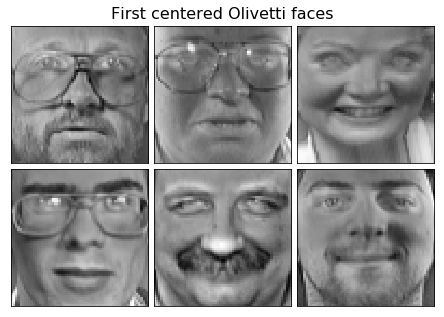

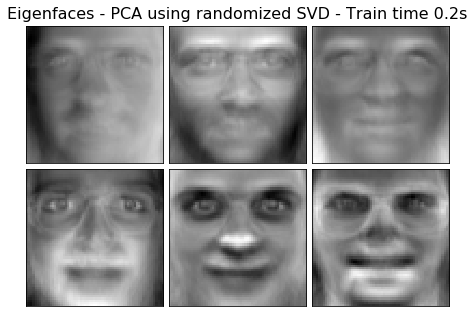

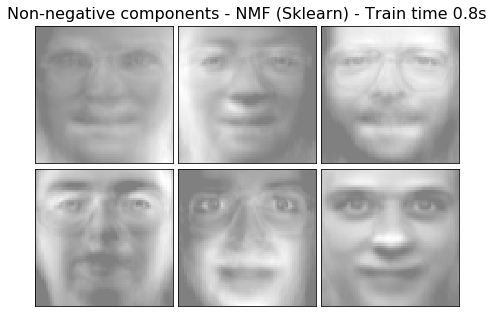

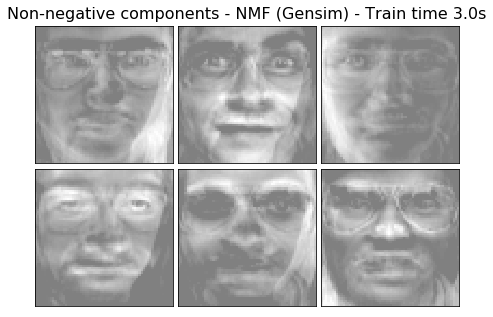

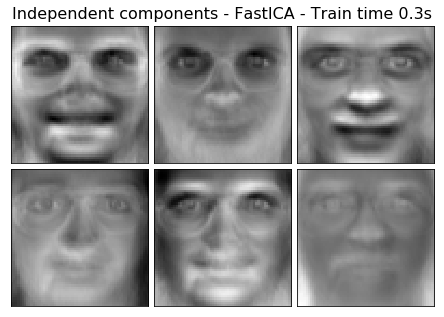

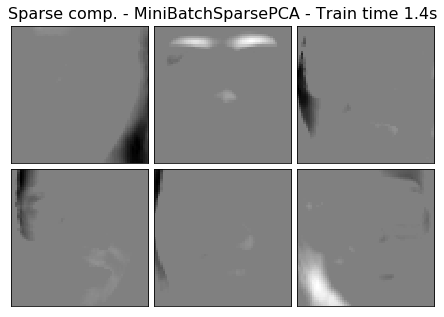

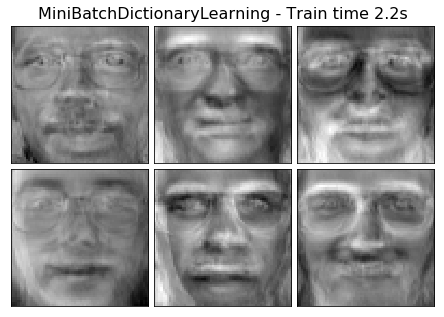

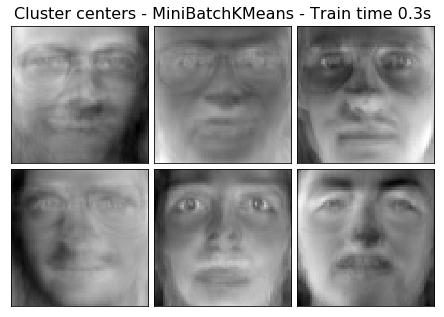

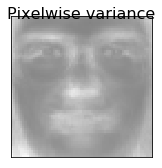

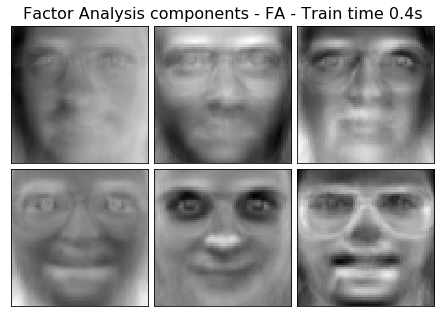

In [94]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),
    
    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
        chunksize=10,
        id2word={idx:idx for idx in range(faces.shape[1])},
        num_topics=n_components,
        passes=5,
        minimum_probability=0
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

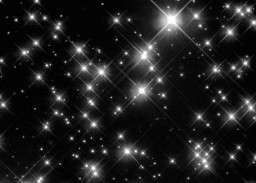

In [17]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [18]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [19]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 374 ms, sys: 560 ms, total: 934 ms
Wall time: 262 ms


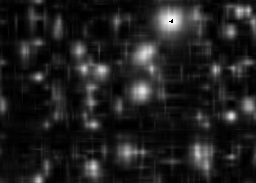

In [20]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [21]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [22]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-08-20 22:15:22,726 : INFO : h_r_error: 17211892.5
2018-08-20 22:15:22,729 : INFO : h_r_error: 12284515.111163257
2018-08-20 22:15:22,731 : INFO : h_r_error: 11201387.638214733
2018-08-20 22:15:22,734 : INFO : h_r_error: 10815579.549704548
2018-08-20 22:15:22,738 : INFO : h_r_error: 10646539.06006998
2018-08-20 22:15:22,747 : INFO : h_r_error: 10558409.831047071
2018-08-20 22:15:22,755 : INFO : h_r_error: 10507775.272428757
2018-08-20 22:15:22,757 : INFO : h_r_error: 10475469.606854783
2018-08-20 22:15:22,759 : INFO : h_r_error: 10453925.335400445
2018-08-20 22:15:22,762 : INFO : h_r_error: 10439939.102116534
2018-08-20 22:15:22,784 : INFO : w_error: 10430366.610691467
2018-08-20 22:15:22,788 : INFO : w_error: 11466405.186009312
2018-08-20 22:15:22,791 : INFO : w_error: 10938537.274967317
2018-08-20 22:15:22,793 : INFO : w_error: 10835183.946454465
2018-08-20 22:15:22,799 : INFO : w_error: 10808896.588521175
2018-08-20 22:15:22,803 : INFO : w_error: 10800700.69189361
2018-08-20 22:

2018-08-20 22:15:23,774 : INFO : w_error: 2366899.5684030103
2018-08-20 22:15:23,780 : INFO : w_error: 2347964.180692087
2018-08-20 22:15:23,787 : INFO : w_error: 2332331.149509242
2018-08-20 22:15:23,791 : INFO : w_error: 2319290.024670701
2018-08-20 22:15:23,794 : INFO : w_error: 2308301.644607859
2018-08-20 22:15:23,811 : INFO : w_error: 2298998.176426708
2018-08-20 22:15:23,814 : INFO : w_error: 2291054.8383098356
2018-08-20 22:15:23,818 : INFO : w_error: 2284233.8267418565
2018-08-20 22:15:23,821 : INFO : w_error: 2278346.4815429775
2018-08-20 22:15:23,823 : INFO : w_error: 2273239.326070163
2018-08-20 22:15:23,824 : INFO : w_error: 2268800.1953844256
2018-08-20 22:15:23,826 : INFO : w_error: 2264918.837606525
2018-08-20 22:15:23,828 : INFO : w_error: 2261511.2618650706
2018-08-20 22:15:23,830 : INFO : w_error: 2258510.001427239
2018-08-20 22:15:23,831 : INFO : w_error: 2255858.510132532
2018-08-20 22:15:23,833 : INFO : w_error: 2253518.01968442
2018-08-20 22:15:23,834 : INFO : w_

CPU times: user 1.3 s, sys: 1.91 s, total: 3.22 s
Wall time: 1.63 s


In [23]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

2018-08-20 22:15:24,333 : INFO : h_r_error: 1641779.1711565189
2018-08-20 22:15:24,335 : INFO : h_r_error: 118028.68383364937
2018-08-20 22:15:24,337 : INFO : h_r_error: 105616.73503369163
2018-08-20 22:15:24,339 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,344 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,345 : INFO : h_r_error: 88296.81129174746
2018-08-20 22:15:24,347 : INFO : h_r_error: 75598.49700209008
2018-08-20 22:15:24,350 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,352 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,353 : INFO : h_r_error: 40896.39022296863
2018-08-20 22:15:24,354 : INFO : h_r_error: 32494.67090191547
2018-08-20 22:15:24,356 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,366 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,368 : INFO : h_r_error: 44930.159607806534
2018-08-20 22:15:24,370 : INFO : h_r_error: 36557.7492240496
2018-08-20 22:15:24,371 : INFO : h_r_error: 35312.9484972738
20

2018-08-20 22:15:24,658 : INFO : h_r_error: 134685.80489629053
2018-08-20 22:15:24,661 : INFO : h_r_error: 113538.95669792594
2018-08-20 22:15:24,665 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,669 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,671 : INFO : h_r_error: 122345.42442740352
2018-08-20 22:15:24,672 : INFO : h_r_error: 101206.04117840753
2018-08-20 22:15:24,673 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,674 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,676 : INFO : h_r_error: 116266.06525752878
2018-08-20 22:15:24,677 : INFO : h_r_error: 96812.1429100881
2018-08-20 22:15:24,683 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,686 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,687 : INFO : h_r_error: 124976.11247413699
2018-08-20 22:15:24,689 : INFO : h_r_error: 105696.72347766797
2018-08-20 22:15:24,690 : INFO : h_r_error: 105516.7395837665
2018-08-20 22:15:24,691 : INFO : h_r_error: 105516.739583766

2018-08-20 22:15:25,015 : INFO : h_r_error: 58344.200783367785
2018-08-20 22:15:25,020 : INFO : h_r_error: 56997.1979143896
2018-08-20 22:15:25,023 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,025 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,031 : INFO : h_r_error: 55804.84516396389
2018-08-20 22:15:25,032 : INFO : h_r_error: 49720.76312800324
2018-08-20 22:15:25,034 : INFO : h_r_error: 48669.3293093283
2018-08-20 22:15:25,036 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,039 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,042 : INFO : h_r_error: 50232.78247908833
2018-08-20 22:15:25,045 : INFO : h_r_error: 43460.18499959944
2018-08-20 22:15:25,047 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,049 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,051 : INFO : h_r_error: 70689.83802178742
2018-08-20 22:15:25,053 : INFO : h_r_error: 54799.329874802635
2018-08-20 22:15:25,057 : INFO : h_r_error: 53914.8316747843
2018-08-2

2018-08-20 22:15:25,356 : INFO : h_r_error: 123923.46378028487
2018-08-20 22:15:25,357 : INFO : h_r_error: 91401.7915719367
2018-08-20 22:15:25,359 : INFO : h_r_error: 85191.39582673303
2018-08-20 22:15:25,361 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,364 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,365 : INFO : h_r_error: 111957.92974291708
2018-08-20 22:15:25,367 : INFO : h_r_error: 90673.10717043538
2018-08-20 22:15:25,368 : INFO : h_r_error: 86795.48708018255
2018-08-20 22:15:25,370 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,372 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,374 : INFO : h_r_error: 78116.94232451699
2018-08-20 22:15:25,389 : INFO : h_r_error: 64864.185952766085
2018-08-20 22:15:25,403 : INFO : h_r_error: 62627.20138398043
2018-08-20 22:15:25,406 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,417 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,418 : INFO : h_r_error: 49500.7753928332
2018-08-2

2018-08-20 22:15:25,908 : INFO : h_r_error: 20608.810430887163
2018-08-20 22:15:25,910 : INFO : h_r_error: 20433.54257729559
2018-08-20 22:15:25,911 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,913 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,916 : INFO : h_r_error: 28200.31679054761
2018-08-20 22:15:25,919 : INFO : h_r_error: 23300.098733814248
2018-08-20 22:15:25,929 : INFO : h_r_error: 22137.1510942318
2018-08-20 22:15:25,931 : INFO : h_r_error: 21810.085864093246
2018-08-20 22:15:25,932 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,934 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,935 : INFO : h_r_error: 15260.366709589653
2018-08-20 22:15:25,936 : INFO : h_r_error: 11872.08315938859
2018-08-20 22:15:25,937 : INFO : h_r_error: 10908.905597899073
2018-08-20 22:15:25,938 : INFO : h_r_error: 10684.630020773682
2018-08-20 22:15:25,939 : INFO : h_r_error: 10651.271246929588
2018-08-20 22:15:25,941 : INFO : h_r_error: 10651.2712469295

2018-08-20 22:15:26,250 : INFO : h_r_error: 89193.15992567304
2018-08-20 22:15:26,251 : INFO : h_r_error: 82326.7193949022
2018-08-20 22:15:26,253 : INFO : h_r_error: 81654.10188430984
2018-08-20 22:15:26,254 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,256 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,258 : INFO : h_r_error: 195202.30314943343
2018-08-20 22:15:26,259 : INFO : h_r_error: 87377.33791727532
2018-08-20 22:15:26,261 : INFO : h_r_error: 80672.67496760779
2018-08-20 22:15:26,262 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,268 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,271 : INFO : h_r_error: 144824.23872960033
2018-08-20 22:15:26,272 : INFO : h_r_error: 55900.50694270172
2018-08-20 22:15:26,273 : INFO : h_r_error: 50456.945266342926
2018-08-20 22:15:26,275 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,277 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,278 : INFO : h_r_error: 120497.96569875091
2018-

2018-08-20 22:15:26,582 : INFO : h_r_error: 18959.722842143907
2018-08-20 22:15:26,583 : INFO : h_r_error: 83876.31226742358
2018-08-20 22:15:26,584 : INFO : h_r_error: 27066.441250717817
2018-08-20 22:15:26,586 : INFO : h_r_error: 23671.276967366928
2018-08-20 22:15:26,587 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,590 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,591 : INFO : h_r_error: 87851.09522030315
2018-08-20 22:15:26,593 : INFO : h_r_error: 36557.55519906569
2018-08-20 22:15:26,596 : INFO : h_r_error: 32920.158554937225
2018-08-20 22:15:26,605 : INFO : h_r_error: 32884.0633641823


### Reconstructed matrix:

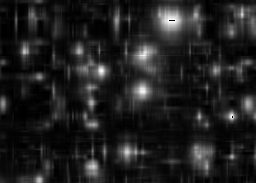

In [24]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')